In [1]:
#!/usr/bin/env python3.6
# -*- coding: utf-8 -*-

In [2]:
# Imports
import sys
import joblib
import numpy as np
from matplotlib import animation
from IPython.display import HTML
from matplotlib import pyplot as plt
import mpl_toolkits.mplot3d.axes3d as p3

In [3]:
#np.random.seed(20)
np.set_printoptions(threshold=sys.maxsize)

In [4]:
%matplotlib inline

In [5]:
%store -r X_motion_relative
%store -r Y_motion_relative
print(X_motion_relative.shape)
print(Y_motion_relative.shape)

(27032, 27)
(27032, 8)


# Multivariate Linear Regression (Foot prediction)

The input will use initially only:

- **HighCmd: fwd, side, rot speeds**
- **HighState: fwd, side, rot speeds, footPosition2Body (FR)**

and as output we seek to predict the following:

- **footPosition2Body (FR)**

In [6]:
import sklearn
from sklearn import metrics
from sklearn.feature_selection import RFE
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures 
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [7]:
# Entries where FL/RR are swinging
idxs = np.where(X_motion_relative[:, 25] == 1)[0]
X_motion_relative_FL_RR = X_motion_relative[idxs]
Y_motion_relative_FL_RR = Y_motion_relative[idxs]

## Predict FL foot -> x

In [8]:
X_motion_relative_FL_RR.shape

(13320, 27)

In [9]:
X_motion_relative_FL_RR[0, :]

array([ 1.00000000e-01,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  7.67128601e-27,  1.56430903e-26,
        7.73122404e-03,  9.99970114e-01,  2.02702748e-04,  1.18196215e-04,
        1.73000000e-01,  1.36000000e-01, -3.40000000e-01,  2.06000000e-01,
       -1.35000000e-01, -3.39000000e-01, -2.68000000e-01,  1.36000000e-01,
       -3.40000000e-01, -2.92000000e-01, -1.36000000e-01, -3.40000000e-01,
        0.00000000e+00,  1.00000000e+00,  1.63241605e+09])

In [10]:
Y_motion_relative_FL_RR[0, :]

array([ 0.029, -0.004, -0.027, -0.002, -0.025,  0.001,  0.02 , -0.001])

### Linear Regression

In [11]:
# Input
#X = np.hstack((X_motion_relative_FL_RR[:, :2], np.array([X_motion_relative_FL_RR[:, 5]]).T,
#               X_motion_relative_FL_RR[:, 6:8], np.array([X_motion_relative_FL_RR[:, 11]]).T,
#               np.array([X_motion_relative_FL_RR[:, 12]]).T, np.array([X_motion_relative_FL_RR[:, 15]]).T))
#X = np.hstack((X_motion_relative_FL_RR[:, :2], np.array([X_motion_relative_FL_RR[:, 5]]).T,
#               np.array([X_motion_relative_FL_RR[:, 12]]).T, np.array([X_motion_relative_FL_RR[:, 15]]).T))
X = np.hstack((X_motion_relative_FL_RR[:, :2],
               np.array([X_motion_relative_FL_RR[:, 5]]).T,
               X_motion_relative_FL_RR[:, 12:14],
               X_motion_relative_FL_RR[:, 15:17],
               X_motion_relative_FL_RR[:, 18:20],
               X_motion_relative_FL_RR[:, 21:23]))

# Target
Y = np.array([Y_motion_relative_FL_RR[:, 6]]).T

assert Y.shape[0] == X.shape[0]

# Split data into train and test set
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size = 0.8, test_size=0.2, shuffle=True, random_state=100)

# Create the model
model_rr_relative_swinging_x = LinearRegression()

# Fit the model
model_rr_relative_swinging_x.fit(X_train, Y_train)

# Predict
predictions = model_rr_relative_swinging_x.predict(X_test)

# Stats
print('R2: ', r2_score(predictions, Y_test))
print('RMSE: ', np.sqrt(mean_squared_error(Y_test, predictions)))
print("The lowest error is: ", np.min(np.abs(predictions - Y_test)))
print("The highest error is: ", np.max(np.abs(predictions - Y_test)))
print("The avg. error is: ", np.mean(np.abs(predictions - Y_test)))
#print("Seq of errors (descendant): \n", sorted(np.abs(predictions - Y_test).tolist(), reverse=True))

R2:  0.9932230180587514
RMSE:  0.004358757414409975
The lowest error is:  6.595140696202817e-07
The highest error is:  0.04699374180098059
The avg. error is:  0.0021211262184737375


In [12]:
model_rr_relative_swinging_x.coef_

array([[ 5.92483902e-02,  5.98820152e-04,  3.74287507e-03,
        -2.71333921e-01, -1.55467217e-01,  1.02390882e-01,
         1.85833887e-01,  2.11099138e-01, -1.34491619e-01,
        -8.86573251e-01,  1.74333171e-01]])

In [13]:
model_rr_relative_swinging_x.intercept_

array([-0.07321299])

Text(0, 0.5, 'Predictions')

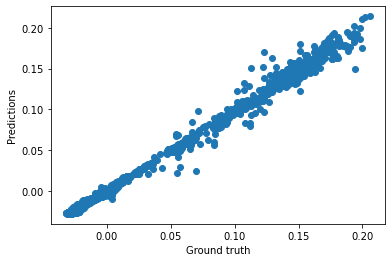

In [15]:
## The line / model
plt.scatter(Y_test, predictions)
plt.xlabel("Ground truth")
plt.ylabel("Predictions")

In [13]:
%store model_rr_relative_swinging_x

Stored 'model_rr_relative_swinging_x' (LinearRegression)


In [14]:
#for idx, prediction in enumerate(predictions):
#    print(f'Start: {X_test[idx, 6]}. Groundtruth: {Y_test[idx]}. Predicted: {prediction}')

In [15]:
# Save model
joblib.dump(model_rr_relative_swinging_x, "/home/itaouil/workspace/aliengo_ws/src/aliengo_navigation/models/protocol3/relative/model_rr_relative_swinging_x.sav")

['/home/itaouil/workspace/aliengo_ws/src/aliengo_navigation/models/protocol3/relative/model_rr_relative_swinging_x.sav']

### Predict FL foot -> y

In [16]:
# Input
#X = np.hstack((X_motion_relative_FL_RR[:, :2], np.array([X_motion_relative_FL_RR[:, 5]]).T,
#               X_motion_relative_FL_RR[:, 6:8], np.array([X_motion_relative_FL_RR[:, 11]]).T,
#               np.array([X_motion_relative_FL_RR[:, 12]]).T, np.array([X_motion_relative_FL_RR[:, 15]]).T))
#X = np.hstack((X_motion_relative_FL_RR[:, :2], np.array([X_motion_relative_FL_RR[:, 5]]).T,
#               np.array([X_motion_relative_FL_RR[:, 12]]).T, np.array([X_motion_relative_FL_RR[:, 15]]).T))
X = np.hstack((X_motion_relative_FL_RR[:, :2],
               np.array([X_motion_relative_FL_RR[:, 5]]).T,
               X_motion_relative_FL_RR[:, 12:14],
               X_motion_relative_FL_RR[:, 15:17],
               X_motion_relative_FL_RR[:, 18:20],
               X_motion_relative_FL_RR[:, 21:23]))
# Target
Y = np.array([Y_motion_relative_FL_RR[:, 7]]).T

assert Y.shape[0] == X.shape[0]

# Split data into train and test set
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size = 0.8, shuffle=True, random_state=100)

# Create the model
model_rr_relative_swinging_y = LinearRegression()

# Fit the model
model_rr_relative_swinging_y.fit(X_train, Y_train)

# Predict
predictions = model_rr_relative_swinging_y.predict(X_test)

# Stats
print('R2: ', r2_score(predictions, Y_test))
print('RMSE: ', np.sqrt(mean_squared_error(Y_test, predictions)))
print("The lowest error is: ", np.min(np.abs(predictions - Y_test)))
print("The highest error is: ", np.max(np.abs(predictions - Y_test)))
print("The avg. error is: ", np.mean(np.abs(predictions - Y_test)))
#print("Seq of errors (descendant): \n", sorted(np.abs(predictions - Y_test).tolist(), reverse=True))

R2:  0.9949790409939085
RMSE:  0.003763883068595202
The lowest error is:  1.8206576893053938e-06
The highest error is:  0.029424499693570846
The avg. error is:  0.002538774191326812


In [17]:
model_rr_relative_swinging_y.coef_

array([[ 9.11557581e-04,  7.96752491e-03, -6.12761024e-03,
        -1.69531771e-01, -3.69152908e-02, -8.70984474e-02,
         1.09659174e-01,  7.69277098e-02,  3.90956364e-01,
         1.45873682e-01, -1.22612609e+00]])

In [18]:
model_rr_relative_swinging_y.intercept_

array([-0.09027069])

Text(0, 0.5, 'Predictions')

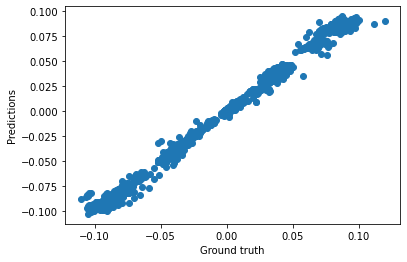

In [19]:
## The line / model
plt.scatter(Y_test, predictions)
plt.xlabel("Ground truth")
plt.ylabel("Predictions")

In [18]:
%store model_rr_relative_swinging_y

Stored 'model_rr_relative_swinging_y' (LinearRegression)


In [61]:
input_ = np.array([[0.  ,0.,    -0.6,    0.183,  0.153,  0.18,  -0.147, -0.277,  0.155, -0.268,
 -0.16, 1]])
print(input_.shape)

(1, 12)


In [62]:
coeff = np.array([[ 9.11557581e-04,  7.96752491e-03, -6.12761024e-03,
        -1.69531771e-01, -3.69152908e-02, -8.70984474e-02,
         1.09659174e-01,  7.69277098e-02,  3.90956364e-01,
         1.45873682e-01, -1.22612609e+00, model_rr_relative_swinging_y.i]])
print(coeff.shape)

(1, 12)


In [63]:
np.dot(input_, coeff.T)

array([[1.13158188]])

In [16]:
for idx, prediction in enumerate(predictions):
    print(f'Input: {X_test[idx]}. Groundtruth: {Y_test[idx]}. Predicted: {prediction}')

Input: [ 0.     0.    -0.6    0.183  0.153  0.18  -0.147 -0.277  0.155 -0.268
 -0.16 ]. Groundtruth: [0.037]. Predicted: [0.04131119]
Input: [ 0.7    0.     0.     0.103  0.142  0.275 -0.136 -0.201  0.135 -0.356
 -0.14 ]. Groundtruth: [0.005]. Predicted: [0.0058412]
Input: [ 0.         -0.3         0.          0.19954579  0.18478185  0.19232212
 -0.17824467 -0.28185517  0.09327966 -0.28236407 -0.09570976]. Groundtruth: [-0.08063067]. Predicted: [-0.07866015]
Input: [ 0.     0.     0.2    0.197  0.128  0.192 -0.129 -0.29   0.131 -0.285
 -0.123]. Groundtruth: [-0.024]. Predicted: [-0.02234231]
Input: [ 0.     0.    -0.6    0.182  0.153  0.18  -0.146 -0.278  0.154 -0.268
 -0.161]. Groundtruth: [0.042]. Predicted: [0.04234862]
Input: [ 0.     0.    -0.4    0.182  0.153  0.18  -0.145 -0.279  0.153 -0.268
 -0.161]. Groundtruth: [0.042]. Predicted: [0.04076488]
Input: [ 0.     0.     0.5    0.2    0.126  0.196 -0.12  -0.297  0.117 -0.288
 -0.117]. Groundtruth: [-0.036]. Predicted: [-0.0377830

In [20]:
# Save model
joblib.dump(model_rr_relative_swinging_y, "/home/itaouil/workspace/aliengo_ws/src/aliengo_navigation/models/protocol3/relative/model_rr_relative_swinging_y.sav")

['/home/itaouil/workspace/aliengo_ws/src/aliengo_navigation/models/protocol3/relative/model_rr_relative_swinging_y.sav']